<hr style='height:3pt'>

# Meme Caption Generator

## Models and results

Anthony Rentsch, Lipika Ramaswamy, Nicholas Stern

<hr style='height:3pt'>

In this notebook, we walk through the following: 


0. [**Set up**](#setup)
1. [**Model architecture**](#arch)
3. [**Data Generation**](#data)
2. [**Model training**](#training)
3. [**Inference**](#inference)
4. [**Evauation**](#eval)

**Note: Do not run all cells as our inference model is stochastic.**

<hr style='height:3pt'>

## 0. Set up <a name="setup"></a>

<hr style='height:3pt'>

In [1]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, \
    LSTM, Embedding, TimeDistributed, RepeatVector, Activation, Flatten, Add, Dot, Concatenate
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os
import cv2
from pickle_utils import pickle_load, pickle_dump
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Check GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

<hr style='height:3pt'>

## 1. Model Architecture <a name="arch"></a>

The model architecture we use is shown in the images below. 

**TL;DR**  
Our models are set up to have an encoder decoder architecture. The encoder is constructed to provide a meaningful initial state to the decoder to initiate the text generation process. We use a pretrained CNN (Inception V3 with the final classification layer peeled off) to obtain a latent representation of the image. We process the image labels in two different ways, as shown in the flowcharts below. In version 1, we get average GloVe embeddings of words in the label, concatenate them with the output of the CNN, and apply a Dense layer with 300 nodes. This is passed into the decoder LSTM as the initial state. In version 2, we pad the image labels to be of length 20, and pass them through an LSTM. The final hidden and cell states of this encoder LSTM are passed into the decoder LSTM. The decoder, as alluded to before, is an LSTM that takes on initial states depending on the model architecture, and takes the true captions as input. In version 1, we directly apply a Time Distributed Dense layer to get probabilities for all the words in our vocabulary. In version 2, we implement an Attention mechanism and then apply a Time Distributed Dense layer. We use these outputs for inference. 

<hr style='height:3pt'>

#### Load embeddings and specify parameters

In [3]:
# load embeddings
embeddings, idx2word, word2idx, captions = pickle_load("full_clean_processed_data.pkl")
captions.image = captions.image.apply(lambda x: x.strip(' '))

In [4]:
# input parameters
img_shape = (300,300,3)             # image shape
vocab_size = embeddings.shape[0]    # size of vocabulary
embedding_size = 300                # size of glove embeddings, 300D 
maxlen = 20                         # maximum length of the caption in hidden state
hidden_units = embedding_size       # length of word vectors i.e. embedding size
batch_size = 32

# hyper parameters
clip_norm = 1.0
learning_rate = 0.01
decay_rate = 0.7                   # for RMS Prop

#### Below is version 1 of the model with no attention or training of embeddings in the encoder
We roughly follow [Dank Learning](https://arxiv.org/pdf/1806.04510.pdf) model architecture 2.

<img src="meme_model_vanilla_diagram.png" alt = 'vanillamodel' style = "width: 800px">

In [5]:
def build_model(img_shape, vocab_size, embedding_size, maxlen, hidden_units, clip_norm, learning_rate, decay_rate = decay_rate):
    '''
    =============
      ENCODER
    =============
    Inputs: 
        1. Image (300, 300, 3)
        2. GloVe-ed label embeddings (300,)
        
    Model:
        3. Pretrained CNN with classification layer peeled off
              - Output size: (2048,)
        4. Concatenate with label embeding of size
              - Output size: (2348,)
        5. MLP: Dense layer with 300 nodes
              - Output size: (300,) <-- This is the image embedding
    '''

    # 1. Image Input
    input_img = keras.Input(shape=img_shape, name='image_input')
    
    # 2. Label Embedding
    label_emb = keras.Input(shape=(300,), name='image_label_input')

    # 3. Define Pretrained CNN - Inception V3
    cnnModel = InceptionV3(weights='imagenet', 
                           include_top=False,        # this removes the final dense layer
                           input_shape=img_shape, 
                           pooling = 'avg')

    # freeze all convolutional InceptionV3 layers
    for layer in cnnModel.layers:
        layer.trainable = False

    # Get image embedding <- this is a model output
    image_emb = cnnModel(input_img)

    # 4. Concatenate image embedding with label embedding
    concat = keras.layers.Concatenate(axis=1)([image_emb, label_emb])
    
    # 5. MLP with 300 nodes
    full_img_embedding = Dense(300, activation='relu')(concat)

    # ==== ENCODER MODEL ====
    encoder = keras.Model(inputs=[input_img, label_emb], outputs=full_img_embedding)
    

    '''
    =============
      DECODER
    =============
    Inputs: 
        8. Caption (tokenized) (20,) <- limiting caption length to 20
        9. LSTM hidden state from encoder
        
    Model:
        10. Embedding layer that uses the GloVe embedding matrix, and is set to be trainable
              - Output size: (20, 300)
        11. LSTM
              -  Output size: (20, 300)
        12. Time Distributed layer to apply Dense layer to all the time step outputs
              - Output size: (20, 40000)
        13. Activation of softmax to get values between 0 and 1
              - Output size: (20, 40000)
    '''

    # 8. Caption
    input_caption = keras.Input(shape = (maxlen,), name='image_caption_input')
    
    # 9. Input for the LSTM hidden state and/or cell state
    initial_state_LSTM = encoder([input_img, label_emb])
    

        
    # 10. Embedding layer
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                  input_length=maxlen, embeddings_regularizer = None,
                                  weights = [embeddings], name = 'caption_embeddings', 
                                  trainable = True, mask_zero=True)
    # 11. LSTM
    decoder_LSTM = LSTM(hidden_units, return_sequences=True, return_state=True)

    ## ===== Get embedding and LSTM outputs =====
    decoder_embedding_outputs = decoder_embedding(input_caption)
    decoder_LSTM_outputs, _ , _ = decoder_LSTM(decoder_embedding_outputs, 
                                          initial_state = [initial_state_LSTM,  # hidden state
                                                           initial_state_LSTM]) # cell state
    
    # 12. Time Distributed Layer
    time_distributed = TimeDistributed(Dense(vocab_size, name = 'timedistributed_1'))
    
    # 13. Softmax 
    activation = Activation('softmax')
    
    ## ===== Get time distributed and softmax output =====
    time_distributed_output = time_distributed(decoder_LSTM_outputs)
    decoder_outputs = activation(time_distributed_output)

    # ==============
    #   FULL MODEL
    # ==============   
    model= Model(inputs=[input_img, label_emb, input_caption], outputs=decoder_outputs)
    rmsprop = RMSprop(lr=learning_rate, clipnorm=clip_norm, decay=decay_rate)
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
    
    print(model.summary())
    
    return model ## can add to this function

#### Below is version 2 of the model with trained embeddings in the encoder and an attention mechanism implemented using Dot layers.
We roughly follow [Dank Learning](https://arxiv.org/pdf/1806.04510.pdf) model architecture 3.

<img src="meme_model_lstm.png" alt = 'vanillamodel' style = "width: 800px">

In [6]:
def build_model_attn(img_shape, vocab_size, embedding_size, maxlen, hidden_units, clip_norm, 
                     learning_rate, decay_rate = decay_rate):
    '''
    =============
      ENCODER
    =============
    Inputs: 
        1. Image (,300, 300, 3)
        2. Tokenized label (,30)

    Model:
        3. Pretrained CNN with classification layer peeled off
              - Output of InceptionV3: (2048,)
              - Add layer of size 300
              - Final output: (300,)
        4. LSTM with initial state as the output of CNN (300 dimensional)
              - Input is the tokenized padded label
              - Uses embedding matrix
              - Set embedding matrix to trainable
    '''

    # 1. Image Input
    input_img = keras.Input(shape=img_shape, name='image_input')

    # 2. Label Embedding
    input_label = keras.Input(shape=(maxlen,), name='image_label_input')

    # 3. Define Pretrained CNN - Inception V3
    cnnModel_incomplete = InceptionV3(weights='imagenet', 
                           include_top=False,        # this removes the final dense layer
                           input_shape=img_shape, 
                           pooling = 'avg')

    # freeze all convolutional InceptionV3 layers
    for layer in cnnModel_incomplete.layers:
        layer.trainable = False

    # Get image embedding <- this is a model output
    image_emb = cnnModel_incomplete(input_img)

    # MLP with 300 nodes to get output of image model
    image_emb_reduced = Dense(300, activation='relu')(image_emb)

    # Define CNN model
    cnnModel = keras.Model(inputs=input_img, outputs=image_emb_reduced)

    '''
    =============
      ENCODER
    =============
        4. Embedding layer that uses the GloVe embedding matrix, and is set to be trainable
              - Output size: (20, 300) 

        5. LSTM with initial state as the output of CNN (300 dimensional)
              - Input is the tokenized padded label
              - Uses embedding matrix
              - Set embedding matrix to trainable
    '''

    # 10. Embedding layer
    encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                  input_length=maxlen, embeddings_regularizer = None,
                                  weights = [embeddings], name = 'label_embeddings', 
                                  trainable = True, mask_zero=True)
    # 11. LSTM for image label

    # Prepare input for the LSTM hidden state and/or cell state
    initial_state_LSTM_label = cnnModel(input_img)
    encoder_LSTM = LSTM(hidden_units, return_sequences=True, return_state=True)

    ## ===== Get embedding and LSTM outputs =====
    encoder_embedding_outputs = encoder_embedding(input_label)
    encoder_LSTM_outputs, hidden_state_encoder, cell_state_encoder = encoder_LSTM(
                                                            encoder_embedding_outputs, 
                                                            initial_state = [initial_state_LSTM_label,  # hidden state
                                                                            initial_state_LSTM_label]) # cell state

    encoder = keras.Model(inputs=[input_img, input_label], outputs=encoder_LSTM_outputs)

    '''
    =============
      DECODER
    =============
    Inputs: 
        8. Caption (tokenized) (20,) <- limiting caption length to 20
        9. LSTM hidden state from encoder

    Model:
        10. Embedding layer that uses the GloVe embedding matrix, and is set to be trainable
              - Output size: (20, 300)
        11. LSTM
              -  Output size: (20, 300)
        12. Time Distributed layer to apply Dense layer to all the time step outputs
              - Output size: (20, 40000)
        13. Activation of softmax to get values between 0 and 1
              - Output size: (20, 40000)
    '''

    # 8. Caption
    input_caption = keras.Input(shape = (maxlen,), name='image_caption_input')

    # 9. Input for the LSTM hidden state and/or cell state
    # initial_state_LSTM = encoder([input_img, label_emb])

    # 10. Embedding layer
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                  input_length=maxlen, embeddings_regularizer = None,
                                  weights = [embeddings], name = 'caption_embeddings', 
                                  trainable = True, mask_zero=True)
    # 11. LSTM
    decoder_LSTM = LSTM(hidden_units, return_sequences=True, return_state=True)

    ## ===== Get embedding and LSTM outputs =====
    decoder_embedding_outputs = decoder_embedding(input_caption)
    decoder_LSTM_outputs, _ , _ = decoder_LSTM(decoder_embedding_outputs, 
                                          initial_state = [hidden_state_encoder,  # hidden state
                                                           cell_state_encoder])   # cell state

    #ATTENTION
    attention = Dot(axes = [2,2])([encoder_LSTM_outputs, decoder_LSTM_outputs])
    attention = Activation('softmax')(attention)
    context = Dot(axes = [2,1])([attention, encoder_LSTM_outputs])
    decoder_combined_context = Concatenate()([context, decoder_LSTM_outputs])

    #time distributed layer, probability predictions for all unique words
    decoder_time_distributed = TimeDistributed(Dense(vocab_size, name = 'decoder_timedistributed'))
    decoder_activation = Activation('softmax', name = 'decoder_activation')
    decoder_outputs = decoder_activation(decoder_time_distributed(decoder_combined_context))

    '''
    ==============
      FULL MODEL
    ==============   
    '''

    model= Model(inputs=[input_img, input_label, input_caption], outputs=decoder_outputs)
    rmsprop = RMSprop(lr=learning_rate, clipnorm=clip_norm, decay=decay_rate)
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop)

    print(model.summary())
    
    return model

In [7]:
# build model - VERSION 1
meme_model_v1 = build_model(img_shape, vocab_size, embedding_size, maxlen, 
                            hidden_units, clip_norm, learning_rate)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_caption_input (InputLayer (None, 20)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
image_label_input (InputLayer)  (None, 300)          0                                            
__________________________________________________________________________________________________
caption_embeddings (Embedding)  (None, 20, 300)      11012700    image_caption_input[0][0]        
__________________________________________________________________________________________________
model_1 (M

In [8]:
# build model - VERSION 2
meme_model_v2 = build_model_attn(img_shape, vocab_size, embedding_size, maxlen, 
                                 hidden_units, clip_norm, learning_rate)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_label_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
label_embeddings (Embedding)    (None, 20, 300)      11012700    image_label_input[0][0]          
__________________________________________________________________________________________________
model_3 (Model)                 (None, 300)          22417484    image_input[0][0]                
__________________________________________________________________________________________________
image_capt

<hr style='height:3pt'>

## 2. Data Generation <a name="data"></a>

The `data_gen1` function returns average embeddings across all words in the image label for version 1 of the model, while `data_gen2` returns tokenized image labels for version 2 of the model. 

<hr style='height:3pt'>

In [10]:
def data_gen1(df, embeddings, word2idx, image_dict, batch_size=32, im_dim=(300, 300, 3)):
    '''
    Data generator
    
    Inputs:
        df - Pandas dataframe with caption information
        embeddings - matrix of embeddings to map from word indices
        word2idx - matrix to convert words to indices (for image labels)
        image_dict - dictionary containing the image pixel data, keys are labels
        
    Outputs: (batch of batch_size)
        images - batch of pre-processed images
        label_embs - batch of averaged image label embeddings
        caption_inds - batch of caption indices 
        targets - batch of sequences of one-hot encoded sparse vocab vectors 
        
    '''
    while 1:  # needed for keras generator
        # Shuffle data
        df_new = df.sample(frac=1).reset_index(drop=True)

        # Split into batches
        split_ind = list(range(0, df_new.shape[0], batch_size))
        batches = np.array_split(df_new, split_ind[1:])
        for i, batch in enumerate(batches):
            
            # Prepare matrices to hold data
            images = np.zeros((batch.shape[0], im_dim[0], im_dim[1], im_dim[2]))
            label_embs = np.zeros((batch.shape[0], embeddings.shape[1]))
            caption_inds = np.zeros((batch.shape[0], maxlen))
            targets = np.zeros((batch.shape[0], maxlen, vocab_size))
            
            for j, (_, row) in enumerate(batch.iterrows()):
                ### Prepare Image Data ###
                im_data = image_dict[row.image]  # get image data for batch
                
                if im_data.shape != im_dim:  # resize if not 300 x 300
                    im_data = cv2.resize(im_data, (im_dim[0], im_dim[1])) 
                    
                im_data = im_data/255  # normalize
                im_data = im_data.astype(np.float32)  # convert to single-precision
                images[j] = im_data  # save the image
                
                ### Prepare Image Labels ###
                im_label_words = row.image.split(' ')
                im_label_ind = [word2idx[word] for word in im_label_words]
                im_label_emb = [embeddings[ind] for ind in im_label_ind]
                im_avg_emb = np.mean(im_label_emb, axis=0)  # average embedding
                label_embs[j] = im_avg_emb
                
                ### Prepare Caption Indices ###
                caption_ind = row.full_padded_caption
                caption_inds[j] = caption_ind 
                
                ### Prepare Target ###
                target_ind = caption_ind[1:]  # target index is right shifted version of caption
                #target_ind.append(1)  # add an extra eos
                target_ind.append(0)  # add an extra eos
                target = to_categorical(target_ind, num_classes=vocab_size)  # matrix of max_len x vocab size
                targets[j] = target
                
                
            yield [images, label_embs, caption_inds], targets

In [11]:
def data_gen2(df, embeddings, word2idx, image_dict, batch_size=32, im_dim=(300, 300, 3)):
    '''
    Data generator
    
    Inputs:
        df - Pandas dataframe with caption information
        embeddings - matrix of embeddings to map from word indices
        word2idx - matrix to convert words to indices (for image labels)
        image_dict - dictionary containing the image pixel data, keys are labels
        
    Outputs: (batch of batch_size)
        images - batch of pre-processed images
        label_embs - batch of averaged image label embeddings
        caption_inds - batch of caption indices 
        targets - batch of sequences of one-hot encoded sparse vocab vectors 
        
    '''
    while 1:  # needed for keras generator
        # Shuffle data
        df_new = df.sample(frac=1).reset_index(drop=True)

        # Split into batches
        split_ind = list(range(0, df_new.shape[0], batch_size))
        batches = np.array_split(df_new, split_ind[1:])
        for i, batch in enumerate(batches):
            
            # Prepare matrices to hold data
            images = np.zeros((batch.shape[0], im_dim[0], im_dim[1], im_dim[2]))
            label_inds = np.zeros((batch.shape[0], maxlen))
            caption_inds = np.zeros((batch.shape[0], maxlen))
            targets = np.zeros((batch.shape[0], maxlen, vocab_size))
            
            for j, (_, row) in enumerate(batch.iterrows()):
                ### Prepare Image Data ###
                im_data = image_dict[row.image]  # get image data for batch
                
                if im_data.shape != im_dim:  # resize if not 300 x 300
                    im_data = cv2.resize(im_data, (im_dim[0], im_dim[1])) 
                    
                im_data = im_data/255  # normalize
                im_data = im_data.astype(np.float32)  # convert to single-precision
                images[j] = im_data  # save the image
                
                ### Prepare Image Labels ###
                label_inds[j] = row.tokenized_padded_label
                
                ### Prepare Caption Indices ###
                caption_ind = row.full_padded_caption
                caption_inds[j] = caption_ind 
                
                ### Prepare Target ###
                target_ind = caption_ind[1:]  # target index is right shifted version of caption
                #target_ind.append(1)  # add an extra eos
                target_ind.append(0)  # add an extra eos
                target = to_categorical(target_ind, num_classes=vocab_size)  # matrix of max_len x vocab size
                targets[j] = target
                
                
            yield [images, label_inds, caption_inds], targets

<hr style='height:3pt'>

## 3. Model Training <a name="training"></a>

<hr style='height:3pt'>

In [9]:
# Create dictionary of image data to store in cache
base_fp = os.getcwd() + '/../memes/'
image_dict = {}
for name, fp in zip(captions.image.unique(), captions.file_path.unique()):
    im = cv2.imread(base_fp + fp)
    assert im is not None # check that the image has been read correctly
    image_dict[name] = im

In [12]:
# Set aside test base image and associated captions
test_image = captions.sample(1, random_state=19).image.values[0]
test_ind = np.where(captions.image == test_image)[0]
train_data = captions.drop(test_ind)
test_data = captions.iloc[test_ind]

In [13]:
# Early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=2, patience=0)

In [ ]:
## Fit model -- VERSION 1

# history_v1 = meme_model_v1.fit_generator(data_gen1(train_data, embeddings, word2idx, image_dict, batch_size=32), 
#                         steps_per_epoch=np.ceil(train_data.shape[0]//batch_size), 
#                         epochs=10,
#                         verbose=1, 
#                         callbacks=[es])

# Save model if good
#meme_model.save('meme_model_v1.h5')

In [ ]:
## Fit model -- VERSION 2

# history_v2 = meme_model_v2.fit_generator(data_gen2(train_data, embeddings, word2idx, image_dict, batch_size=32), 
#                         steps_per_epoch=np.ceil(train_data.shape[0]//batch_size), 
#                         epochs=10,
#                         verbose=1, 
#                         callbacks=[es])

# Save model if good
#meme_model.save('meme_model_v2.h5')

In [16]:
meme_model_v1 = load_model('meme_model_v1.h5')          # load model
meme_model_v2 = load_model('meme_model_v2.h5')          # load model

In [21]:
# meme_model_v1.summary()
# meme_model_v2.summary()

<hr style='height:3pt'>

# 4. Inference <a name="inference"></a>

**We use two methods for inference. The first is a greedy search, where we select the word with the maximum probability at each prediction step. The second is a beam search, where we select a word with a weighted probability according to the top _k_ probabilities.**

<hr style='height:3pt'>

In [33]:
def inference(model, image, im_label, idx2word, greedy=True, k=3, version = 1):
    '''
    Takes model predicted probabilities and converts to text
    
    inputs:
        preds - vector of probability distributions over vocabulary
        image - base image to predict for
        im_label - image label associated with the base image (string)
        idx2word - map of indices to words
        
    outputs:
        caption - predicted caption text
    '''
    # preprocessing
    image = np.expand_dims(image, axis=0)
    
    if version == 1:
        im_label = np.expand_dims(imlabel_to_emb(im_label, embeddings, word2idx), axis=0)
    else:
        im_label = np.expand_dims(imlabel_to_token(im_label, word2idx), axis=0)

    caption = np.zeros((1, 20))
    result = []
    
    for i in range(maxlen):
        # make a prediction
        preds = model.predict([image, im_label, caption])
        
        if greedy:  # implement greedy search
            ind = np.argmax(preds[0, i])
            
        else:  # implement beam search
            top_k_idx = np.argsort(preds[0, i])[-k:]
            #ind = np.random.choice(top_k_idx) # unweighted
            weights = sorted(preds[0, i])[-k:]
            norm_weights = weights/np.sum(weights)
            ind = np.random.choice(top_k_idx, p=norm_weights)
            
        caption[0, i] = ind
        result.append(idx2word[ind])
    return result
  
def imlabel_to_emb(label, embeddings, word2idx):
    '''
    Converts an image label to its average embedding
    '''
    words = label.split(' ')
    word_inds = [word2idx[word] for word in words]
    word_embs = [embeddings[ind] for ind in word_inds]
    
    avg_label_emb = np.mean(word_embs, axis=0)
    return avg_label_emb


def imlabel_to_token(label, word2idx):
    '''
    Converts an image label to its average embedding
    '''
    words = label.split(' ')
    word_inds = [word2idx[word] for word in words]
    word_inds.extend([0]*(maxlen - len(word_inds)))
    return word_inds

## Example Inference on "Smirk Baby"

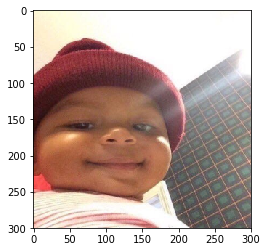

smirk baby


['i',
 'i',
 "don't",
 'know',
 'if',
 'you',
 'want',
 'my',
 'life',
 '<break>',
 'if',
 'you',
 'have',
 'no',
 'power',
 'here',
 '<eos>',
 '<eos>',
 '<eos>',
 'that']

In [39]:
filepath = os.getcwd() + '/../base_images/baby_input.JPG'
im = cv2.imread(filepath)
assert im is not None  # make sure image gets read in

# convert  b,g,r  to r,g,b
im2 = im.copy()
im2[:, :, 0] = im[:, :, 2]
im2[:, :, 2] = im[:, :, 0]

# resize
pred_image = cv2.resize(im2, (300, 300))
plt.imshow(pred_image)
plt.show()

im_label = input()
inference(meme_model_v1, pred_image, im_label, idx2word, greedy=False, k=10, version = 1)

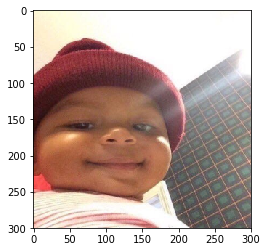

smirk baby


['make',
 'when',
 'a',
 'life',
 'is',
 'like',
 '<break>',
 'and',
 'your',
 'telling',
 'me',
 'this',
 'is',
 'how',
 'to',
 'take',
 'a',
 'little',
 'ring',
 '<eos>']

In [40]:
filepath = os.getcwd() + '/../base_images/baby_input.JPG'
im = cv2.imread(filepath)
assert im is not None  # make sure image gets read in

# convert  b,g,r  to r,g,b
im2 = im.copy()
im2[:, :, 0] = im[:, :, 2]
im2[:, :, 2] = im[:, :, 0]

# resize
pred_image = cv2.resize(im2, (300, 300))
plt.imshow(pred_image)
plt.show()

im_label = input()
inference(meme_model_v2, pred_image, im_label, idx2word, greedy=False, k=10, version = 2)

<hr style='height:3pt'>

# 5. Evaluation <a name="eval"></a>

<hr style='height:3pt'>

There exists a large compendium of techniques to evaluate the similarity between a machine generated caption and a human generated caption. Typically the similarity is computed using a **candidate sentence** generated by an ML algorithm and a **reference sentence** (or multiple) generated by a human. A few examples include:
- **BLEU (2002)**
    - At its core, BLEU is the precision of the candidate sentence, a.k.a, the proportion of words in the candidate sentence that also appear in the reference sentence. It extends to doing multiple n-gram comparisons and taking a weighted average. A more thorough description and example implementation in python can be found [here](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/). Extensions to this method penalize candidate sentences that are shorter than the reference sentence.  
    
    
- **ROUGE (2004)**
    - The recall of the candidate sentence. The proportion of words in the reference sentence that also appear in the candidate sentence. It's essentially the complement to BLEU, and they are often combined in a reported F1 score. Read more [here](https://stackoverflow.com/questions/38045290/text-summarization-evaluation-bleu-vs-rouge)
    
    
- **METEOR (2005)**
    - An extension to the precision/recall combo that algorithmically finds a mapping between the candidate text and the reference text, then uses that to compute the score. Wikipedia says "Results have been presented which give correlation of up to 0.964 with human judgement at the corpus level, compared to BLEU's achievement of 0.817 on the same data set." This method also factors in synonyms. [source](https://en.wikipedia.org/wiki/METEOR)
    
    
- **CIDEr (2015)**
    - This method was developed specifically for image captioning, and extends the previous methods by doing a TF-IDF weighting before comparing the co-occurrence of n-grams between the candidate and reference sentence (actually a set of sentences typically). It is not always effective in situations where it adds disporportionate weight to unimportant words in a sentence that occur infrequently. [source](https://en.wikipedia.org/wiki/METEOR)
    

- **WMD (2015)**
    - Uses word embeddings and something similar to Wasserstein distance to compute the discrepancy between a candidate sentence and a reference sentence. This snares the semantic similarities between two sentences that may not share commong words or even synonyms. [Here](https://vene.ro/blog/word-movers-distance-in-python.html) is a python blog post about it.
    
    
- **SPICE (2016)**
    - SPICE breaks down sentences into semantically meaningful components such as objects, attributes, and relation types. This graph structure is then used to create pairs of words that are semantically related, and computes and F1 score for the tuples between the candidate and the reference sentence(s). [This](https://aclweb.org/anthology/E17-1019) paper does a good job of summarizing this and all the above metrics.
    
    
The paper linked [here](https://aclweb.org/anthology/E17-1019) does a phenomenal job of providing visual and tabular comparisons of each of the aforementioned metrics. The paper also examines their correlation with each other, concluding that the n-gram metrics (BLEU, ROUGE, METEOR, CIDEr) can complement the embedding (WMD) and graph-based (SPICE) ones. Here is a table and figure from the paper:

![](../nick/nlp_metrics.png)


We decided to use BLEU, mainly because it is easily transferrable to vocabularies with lots of slang words, and has a well documented and supported python implementation as a part of the NLTK library. 

# Example w/ BLEU

['i',
 '<break>',
 'i',
 'want',
 'to',
 'live',
 '<eos>',
 '<eos>',
 'this',
 'planet',
 '<eos>',
 'of',
 'by',
 'the',
 'same',
 'of',
 'my',
 'friend',
 '<eos>',
 '<eos>']

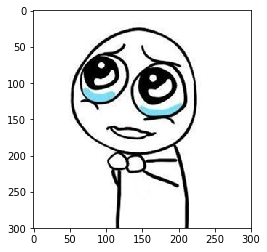

In [47]:
# Visualize the test image
test_im = image_dict[test_image]

# convert  b,g,r  to r,g,b
test_im2 = test_im.copy()
test_im2[:, :, 0] = test_im[:, :, 2]
test_im2[:, :, 2] = test_im[:, :, 0]

# resize
test_im2 = cv2.resize(test_im2, (300, 300))
plt.imshow(test_im2)

# Perform inference to collect candidate caption
inference(meme_model_v1, test_im2, test_image, idx2word, greedy=False, k=10, version = 1)

**Caption: "i ... i want to live"**

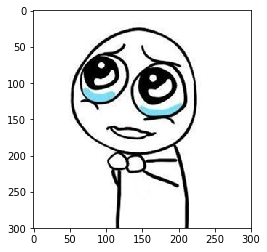

['one',
 'of',
 'them',
 'like',
 '<break>',
 "i'm",
 'sorry',
 'you',
 'got',
 'a',
 'lot',
 'of',
 'the',
 'money',
 'without',
 'any',
 'power',
 '<eos>',
 'in',
 'this']

In [73]:
plt.imshow(test_im2)
plt.show()
# Perform inference on the second model to collect candidate caption
inference(meme_model_v2, test_im2, test_image, idx2word, greedy=False, k=10, version = 2)

**Caption: "one of them like ... 'I'm sorry you got a lot of the money without any power'"**

**We now compare these candidate captions with the corpus of human generated captions for this same image.**

In [49]:
captions.head()

,image,above_text,below_text,file_path,full_caption,full_padded_caption,tokenized_label,tokenized_padded_label
0,y u no,kony,y u no take justin bieber,y-u-no.jpg,<sos> kony <break> y u no take justin bieber ...,"[1, 685, 2, 92, 72, 21, 166, 304, 446, 0, 0, 0...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,y u no,ted,y u no tell us how you met their mother,y-u-no.jpg,<sos> ted <break> y u no tell us how you met t...,"[1, 2522, 2, 92, 72, 21, 201, 245, 131, 5, 124...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,y u no,internet,y u no let me study,y-u-no.jpg,<sos> internet <break> y u no let me study ...,"[1, 250, 2, 92, 72, 21, 182, 15, 814, 0, 0, 0,...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,y u no,i held the door,y u no say thank you,y-u-no.jpg,<sos> i held the door <break> y u no say thank...,"[1, 3, 4844, 4, 800, 2, 92, 72, 21, 80, 1288, ...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,y u no,ugly girl y u play hard to get,when u already hard to want,y-u-no.jpg,<sos> ugly girl y u play hard to get <break> w...,"[1, 1515, 42, 92, 72, 129, 525, 7, 47, 2, 32, ...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [57]:
test_corpus = captions.loc[captions.image == test_image].full_caption.tolist()

In [64]:
def clean_corpus(x):
    '''
    Cleans the test captions
    '''
    x_clean = []
    for caption in x:
        eos_ind = caption.index('<eos>')
        x_clean.append(caption[6:eos_ind-1].split(' '))
        
    return x_clean

In [65]:
test_corpus_clean = clean_corpus(test_corpus)

In [74]:
# 4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoother = SmoothingFunction()  
#reference = [['this', 'is', 'small', 'test']]  # Corpus of documents
#candidate = ['this', 'is', 'a', 'test']  # Candidate document
candidate_v1 = 'i <break> i want to live'
candidate_v2 = "one of them like <break> i'm sorry you got all the money without any power"
score1 = sentence_bleu(test_corpus_clean, candidate_v1, 
                      smoothing_function=smoother.method4, 
                      weights=(0.25, 0.25, 0.25, 0.25))  # ngram weights
print('Model v1 BLEU Score: ', score1)

score2 = sentence_bleu(test_corpus_clean, candidate_v2, 
                      smoothing_function=smoother.method4, 
                      weights=(0.25, 0.25, 0.25, 0.25))  # ngram weights
print('Model v2 BLEU Score: ', score2)

Model v1 BLEU Score:  0.2109882468217856
Model v2 BLEU Score:  0.1755713665213303


The BLEU score for the caption produced by model 1 is higher than that for model 2. Our understanding is that this is expected given the longer caption length generated by model 2, which is more complex.

---